## LSTM on for prediction of federal 10 years bond rates


***Please Note:*** *Import data_contruction file from the correct path*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import data_construction as dc
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

# Data setup

***Please note:*** *Import cleaned_full_data.csv from the correct path*

In [2]:
clean_data = 'cleaned_full_data.csv'

# import data
df = pd.read_csv(clean_data, index_col=0)

# interpolate and join
test = dc.det_interp(df.iloc[:,1])
econ_interp = df.iloc[:,:-1].apply(dc.det_interp, axis=0)
df = pd.concat([econ_interp, df.iloc[:,-1]], axis=1, join="outer")

del df['GS10']

# perform time lags
df['SVENY10_1'] = df['SVENY10'].shift(1)
df['SVENY10_60'] = df['SVENY10'].shift(60)
df_lag_1 = df.iloc[:,:-1].dropna().drop(['SVENY10'], axis=1)
df_lag_60 = df.drop(['SVENY10_1', 
    'SVENY10'], axis=1).dropna()
df = df.iloc[:,:-2]

In [3]:
display(df)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,...,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,probability,SVENY10
1992-02-03,7968.831000,6879.100000,55.965000,7.593844e+05,164213.000000,62.216700,70.459200,68.677100,80.028300,57.009800,90.172400,42.864500,53.690400,34.575900,99.631900,62.086400,74.990900,63.560800,78.808300,2804.000000,0.296594,127207.000000,117753.000000,7.400000,16.700000,3277.000000,2953.000000,3182.000000,1478.000000,1704.000000,4.422000e+05,108311.000000,22142.000000,623.900000,4612.000000,16829.000000,9990.000000,6839.000000,86169.000000,22112.000000,...,2.520000,3.280000,4.230000,5.170000,103.398445,1.456100,127.698900,1.777800,1.182500,122.300000,120.800000,113.800000,98.600000,18.995000,109.800000,138.600000,131.000000,124.500000,185.600000,127.800000,117.300000,149.900000,138.900000,135.600000,135.900000,66.557000,134.522000,65.342000,58.315000,11.890000,13.670000,11.300000,68.800000,2586.200000,64066.000000,189752.080000,744.259500,17.050500,0.500000,7.7153
1992-02-04,7969.526895,6879.394737,55.970368,7.595453e+05,164187.105263,62.243311,70.490542,68.709395,80.066274,57.071358,90.196321,42.891263,53.712226,34.595600,99.704863,62.119300,74.953958,63.577068,78.840526,2811.368421,0.297363,127227.894737,117773.578947,7.400000,16.721053,3284.105263,2945.000000,3182.736842,1475.210526,1707.526316,4.415316e+05,108313.842105,22141.210526,623.826316,4612.473684,16827.736842,9988.894737,6838.842105,86172.631579,22112.052632,...,2.543684,3.294737,4.237368,5.175263,103.537841,1.458905,127.970679,1.774958,1.183042,122.305263,120.800000,113.805263,98.521053,18.990842,109.910526,138.626316,131.015789,124.526316,185.663158,127.821053,117.326316,149.926316,138.921053,135.621053,135.921053,66.565474,134.517474,65.350789,58.324105,11.891579,13.674737,11.301053,69.178947,2587.521053,64009.473684,189811.862632,744.549679,17.006932,0.500000,7.6369
1992-02-05,7970.222789,6879.689474,55.975737,7.597062e+05,164161.210526,62.269921,70.521884,68.741689,80.104247,57.132916,90.220242,42.918026,53.734053,34.615300,99.777826,62.152200,74.917016,63.593337,78.872753,2818.736842,0.298132,127248.789474,117794.157895,7.400000,16.742105,3291.210526,2937.000000,3183.473684,1472.421053,1711.052632,4.408632e+05,108316.684211,22140.421053,623.752632,4612.947368,16826.473684,9987.789474,6838.684211,86176.263158,22112.105263,...,2.567368,3.309474,4.244737,5.180526,103.677236,1.461711,128.242458,1.772116,1.183584,122.310526,120.800000,113.810526,98.442105,18.986684,110.021053,138.652632,131.031579,124.552632,185.726316,127.842105,117.352632,149.952632,138.942105,135.642105,135.942105,66.573947,134.512947,65.359579,58.333211,11.893158,13.679474,11.302105,69.557895,2588.842105,63952.947368,189871.645263,744.839858,16.963363,0.500000,7.5860
1992-02-06,7970.918684,6879.984211,55.981105,7.598670e+05,164135.315789,62.296532,70.553226,68.773984,80.142221,57.194474,90.244163,42.944789,53.755879,34.635000,99.850789,62.185100,74.880074,63.609605,78.904979,2826.105263,0.298901,127269.684211,117814.736842,7.400000,16.763158,3298.315789,2929.000000,3184.210526,1469.631579,1714.578947,4.401947e+05,108319.526316,22139.631579,623.678947,4613.421053,16825.210526,9986.684211,6838.526316,86179.894737,22112.157895,...,2.591053,3.324211,4.252105,5.185789,103.816631,1.464516,128.514237,1.769274,1.184126,122.315789,120.800000,113.815789,98.363158,18.9

Performing PCA

In [4]:
df_pca = df.iloc[:, :-1]
pca = PCA(n_components=1)
pca.fit(df_pca)
df_pca = pd.DataFrame(pca.transform(df_pca), index=df.index)
df_pca['SVENY10'] =  df['SVENY10']

dataset = np.array(df_pca)

#### Dataset creating of LSTM. The resulting set if of the form (n, m, d) 

In [5]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(timestep, len(dataset)):
    a = dataset[i-timestep:i, -1:]
    dataX.append(a)
    dataY.append(dataset[i, -1:])
  return np.array(dataX), np.array(dataY)

### Simple LSTM model

In [6]:
def LSTM_Model(time_step):

  input_layer = Input(shape=(time_step,1))
  lstm_1 = LSTM(50)(input_layer)
  dropout_1 = Dropout(0.2)(lstm_1)

  dense = Dense(1, activation='relu')(dropout_1)

  x = Dense(1, activation='linear')(dense)
  model = Model(inputs=input_layer, outputs=x)
  return model

#### Training the model by looking at from prev day data (timestep = 1)

###### *Please note: Few times it was observed that the model doesn't converge and we might see a graph somewhat like the one shown below. In such scenario, train the model again.*

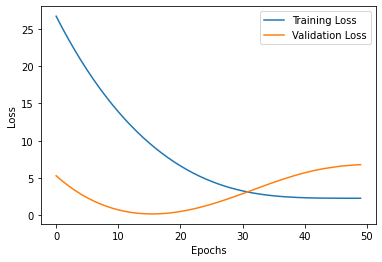

Epoch 1/30
174/174 - 2s - loss: 18.7835 - val_loss: 0.0264
Epoch 2/30
174/174 - 1s - loss: 0.4776 - val_loss: 0.3353
Epoch 3/30
174/174 - 1s - loss: 0.2978 - val_loss: 0.0998
Epoch 4/30
174/174 - 1s - loss: 0.2052 - val_loss: 0.0126
Epoch 5/30
174/174 - 1s - loss: 0.1645 - val_loss: 0.0019
Epoch 6/30
174/174 - 1s - loss: 0.1554 - val_loss: 0.0041
Epoch 7/30
174/174 - 1s - loss: 0.1545 - val_loss: 0.0098
Epoch 8/30
174/174 - 1s - loss: 0.1477 - val_loss: 0.0112
Epoch 9/30
174/174 - 1s - loss: 0.1413 - val_loss: 0.0101
Epoch 10/30
174/174 - 1s - loss: 0.1453 - val_loss: 0.0059
Epoch 11/30
174/174 - 1s - loss: 0.1486 - val_loss: 0.0047
Epoch 12/30
174/174 - 1s - loss: 0.1417 - val_loss: 0.0032
Epoch 13/30
174/174 - 1s - loss: 0.1396 - val_loss: 0.0061
Epoch 14/30
174/174 - 1s - loss: 0.1361 - val_loss: 0.0025
Epoch 15/30
174/174 - 1s - loss: 0.1292 - val_loss: 0.0027
Epoch 16/30
174/174 - 1s - loss: 0.1272 - val_loss: 0.0031
Epoch 17/30
174/174 - 1s - loss: 0.1268 - val_loss: 0.0042
Epoch

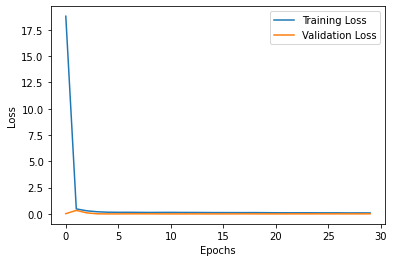

In [18]:
timestep = 1

training_size=int(len(dataset)*0.99)
test_size=len(dataset)-training_size
train_data,test_data=dataset[0:training_size, :],dataset[training_size:len(dataset), :]

X_train, y_train = create_dataset(train_data, timestep)
X_test, y_test = create_dataset(test_data, timestep)

model = LSTM_Model(timestep)
model.compile(optimizer='adam', loss='mse')

# Takes less than a minute to train
history = model.fit(X_train, y_train, epochs=30, verbose=2, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Testing the model

Mean squared error 0.03785994274051926


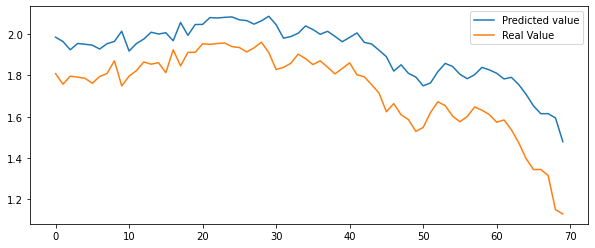

In [19]:
yhat = model.predict(X_test)
print('Mean squared error', mean_squared_error(yhat,y_test))

plt.figure(figsize=(10,4))
plt.plot(yhat)
plt.plot(y_test)
plt.legend(['Predicted value', 'Real Value'], loc='upper right')
plt.show()

### Training by looking at the data from past 60 days (timestep = 60)

Epoch 1/40
171/171 [==============================] - 3s 8ms/step - loss: 2.0708 - val_loss: 0.0116
Epoch 2/40
171/171 [==============================] - 1s 5ms/step - loss: 0.2145 - val_loss: 0.0042
Epoch 3/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1948 - val_loss: 0.0042
Epoch 4/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1755 - val_loss: 0.0052
Epoch 5/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1643 - val_loss: 0.0039
Epoch 6/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1589 - val_loss: 0.0047
Epoch 7/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1515 - val_loss: 0.0044
Epoch 8/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1434 - val_loss: 0.0112
Epoch 9/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1398 - val_loss: 0.0035
Epoch 10/40
171/171 [==============================] - 1s 5ms/step - loss: 0.1303 - val_loss: 0.0036

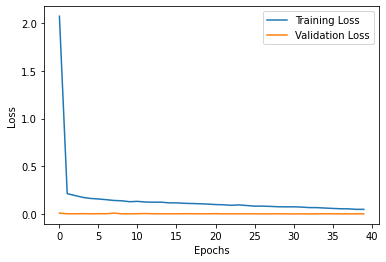

In [24]:
timestep = 60

training_size=int(len(dataset) - 120)
test_size=len(dataset)-training_size
train_data,test_data=dataset[0:training_size, :],dataset[training_size:len(dataset), :]

X_train, y_train = create_dataset(train_data, timestep)
X_test, y_test = create_dataset(test_data, timestep)

model = LSTM_Model(timestep)
model.compile(optimizer='adam', loss='mse')

# Takes less than a minute to train
history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Testing the model

Mean Squared Error: 0.006100704630418581


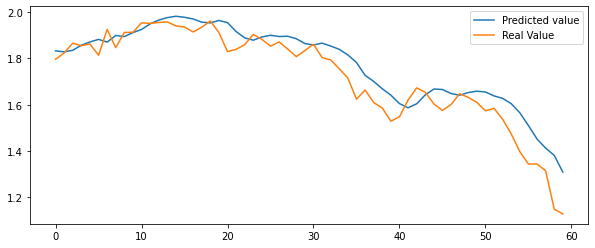

In [25]:
yhat = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(yhat,y_test))


plt.figure(figsize=(10,4))
plt.plot(yhat)
plt.plot(y_test)
plt.legend(['Predicted value', 'Real Value'], loc='upper right')
plt.show()